### Imports

If working in a [suite2p](https://github.com/MouseLand/suite2p) conda environment initialized according to the guide [here](https://github.com/MouseLand/suite2p#installation), using the provided [environment.yml](https://github.com/MouseLand/suite2p/blob/main/environment.yml), all of these dependencies should all be present, with the exception of `skimage`. To obtain it, execute `conda install scikit-image` in your terminal while your **suite2p** conda environment is active.

In [1]:
import os
import re
import shutil

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as plticker
from matplotlib.patches import Rectangle

from skimage import io
from skimage import measure
from tifffile import imsave

from scipy import signal
from scipy.interpolate import interp2d
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

# local imports
from image_arrays import *
from s2p_packer import unpack_hdf

### Activate interactive plotting
By default, inline plots are static. Here we specify one of two options (comment out the undesired command) that will open plots with GUI controls for us.
- **qt ->** figures opened in windows outside the notebook
- **notebook ->** figures within notebook underneath generating cell.

In [2]:
# %matplotlib qt 
%matplotlib notebook

### Paths describing folder structure used for loading in videos and data archives
These, along with naming of the files when they come up, should be altered to align with your setup.

In [3]:
base_path = "/mnt/Data/prerna_noise/"
# data_path = base_path + "second_batch/originals/"
data_path = base_path + "second_batch/bigger_diam/"
s2p_path = data_path + "s2p/"

### Load noise stimulus
Here it is expected to be in `base_path`. Also, create an upsampled version (not currently in use, could be commented out).

In [4]:
raw_noise = io.imread(os.path.join(base_path, "noise_stimulus.tif"))
raw_noise = raw_noise.transpose(0, 2, 1) / 255
zoom_noise = simple_upsample_2D(raw_noise, 16, 16)

# physical dimensions (microns)
stim_width = 400
stim_height = 400

# 60Hz for 60s after 10s delay
noise_xaxis = np.arange(3600) * (1 / 60) + 10.

print("raw noise shape:", raw_noise.shape)
print("zoom noise shape:", zoom_noise.shape)

raw noise shape: (3600, 16, 16)
zoom noise shape: (3600, 256, 256)


### Display noise stimulus used for this experiment / analysis
Use scroll wheel to cycle through the frames of the video (in frame steps set by the `delta` paramater of `StackExplorer`).

<IPython.core.display.Javascript object>


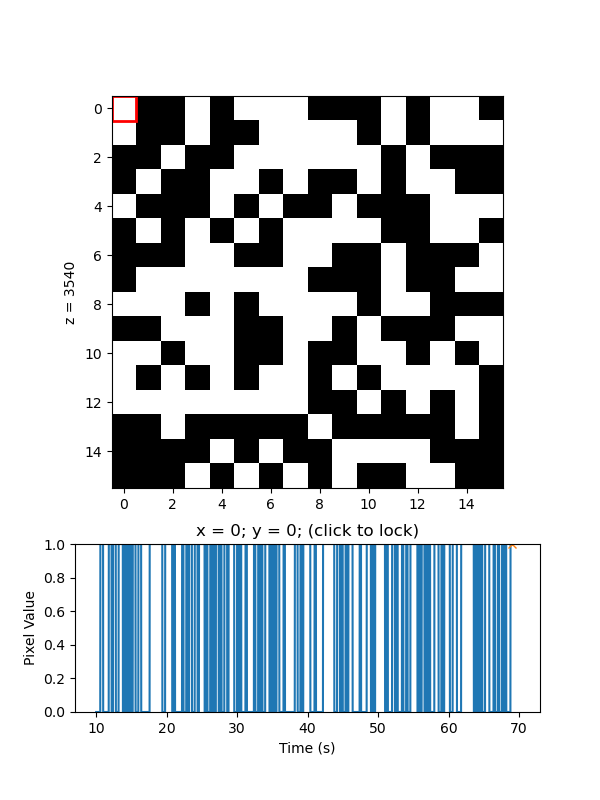

In [5]:
raw_noise_plot = StackExplorer(
    raw_noise,
    zaxis=noise_xaxis,
    delta=10,
    roi_sz=1,
    vmin=0,
    vmax=1,
    figsize=(6, 8)
)
raw_noise_plot.ax[1].set_xlabel("Time (s)")
raw_noise_plot.ax[1].set_ylabel("Pixel Value")

raw_noise_plot.fig.show()

### List tiff files found in the directory indicated by `data_path`

#### Note:
**DD ->** distal. **X** 71.7um, **Y** 28.94um

**PD ->** proximal. **X** 71.7um, **Y** 30.9um

In [6]:
fnames = [
    f for f in os.listdir(data_path) 
    if (f.endswith(".tiff") or f.endswith(".tif"))
]

print("files:")
for f in fnames:
    print("  %s" % f)

files:
  scan14_00051_DD_ch1_400um.tif
  scan14_00051_PD_ch1_400um.tif
  scan14_00055_DD_ch1_200um.tif
  scan14_00055_PD_ch1_200um.tif
  scan9_00035_DD_ch1_400um.tif
  scan9_00035_PD_ch1_400um.tif
  scan9_00040_DD_ch1_200um.tif
  scan9_00040_PD_ch1_200um.tif


### Select (and display) recording to analyse here.
Set `ex_name` to the name shared by the desired `.tif` (found in `data_path`) and the `.h5` (found in `s2p_path`). Use scroll wheel to cycle through the frames of the video (in frame steps set by the `delta` paramater of `StackExplorer`). While moving around the ROI, one may left-click to lock it in the current position, allowing interaction with the z-projection axis underneath.

<IPython.core.display.Javascript object>


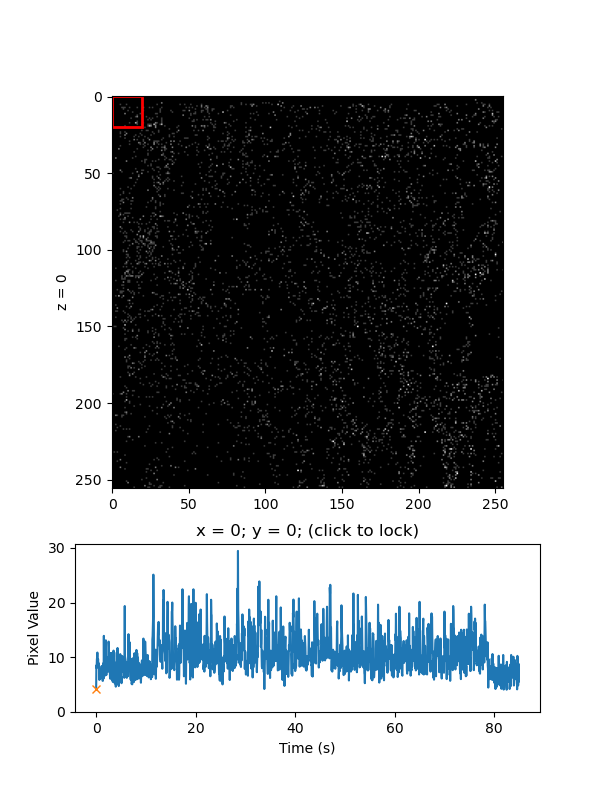

Recording shape: (1700, 256, 256)


In [7]:
ex_name = "scan14_00051_DD_ch1_400um"
ex_stack = io.imread(os.path.join(data_path, ex_name + ".tif"))
with h5.File(os.path.join(s2p_path, ex_name + ".h5"), "r") as f:
    ex_s2p = unpack_hdf(f)

# physical dimensions (in microns)
rec_width = 71.7
rec_height = 28.94

recs_xaxis = np.arange(ex_stack.shape[0]) * 0.05  # 20Hz sampling rate

ex_stack_plot = StackExplorer(
    ex_stack,
    zaxis=recs_xaxis,
    delta=5,
    roi_sz=20,
    vmin=0,
    figsize=(6, 8)
)
ex_stack_plot.ax[1].set_xlabel("Time (s)")
ex_stack_plot.ax[1].set_ylabel("Pixel Value")

print("Recording shape:", ex_stack.shape)
ex_stack_plot.fig.show()

### Pixel map ROIs generated by suite2p
Use scroll wheel to cycle through ROIs.

<IPython.core.display.Javascript object>


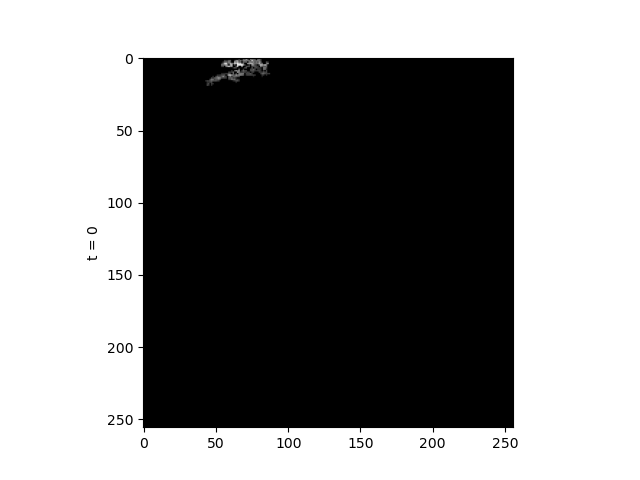

In [8]:
mask_stack = ex_s2p["masks"].transpose(2, 0, 1)
mask_stack_fig, mask_stack_ax = plt.subplots(1)
mask_stack_plot = StackPlotter(
    mask_stack_fig,
    mask_stack_ax,
    mask_stack,
    delta=1
)
mask_stack_fig.show()

### Denoise and signal-noise normalize ROI responses

In [9]:
recs = ex_s2p["recs"] - ex_s2p["Fneu"] * 0.7

# normalize to noise and remove offset
recs /= np.var(recs[:, :198], axis=1).reshape(-1, 1)
recs -= np.mean(recs[:, :198], axis=1).reshape(-1, 1)

def moving_avg(arr, width):
    return np.convolve(arr, np.ones(width) / width, "same")

# filtered = np.stack([butter_bandpass_filter(roi, 0.0001, 1, 10) for roi in recs], axis=0)
filtered = np.stack([signal.savgol_filter(roi, 9, 2) for roi in recs], axis=0)
# filtered = np.stack([moving_avg(roi, 7) for roi in recs], axis=0)

### Explore signals from ROIs, and peak finding parameters
Use scroll wheel to cycle between ROIs, and the input boxes below to
adjust parameters for the peak finding algorithm (see `scipy.signal.find_peaks` for more documentation).

- **prominence:** target difference between a peak and its surrounding mean
- **width:** number of points the value must remain within the fractional **tolerance** range of the peak in order to be considered
- **distance:** minimum allowable interval between peak candidates

<IPython.core.display.Javascript object>


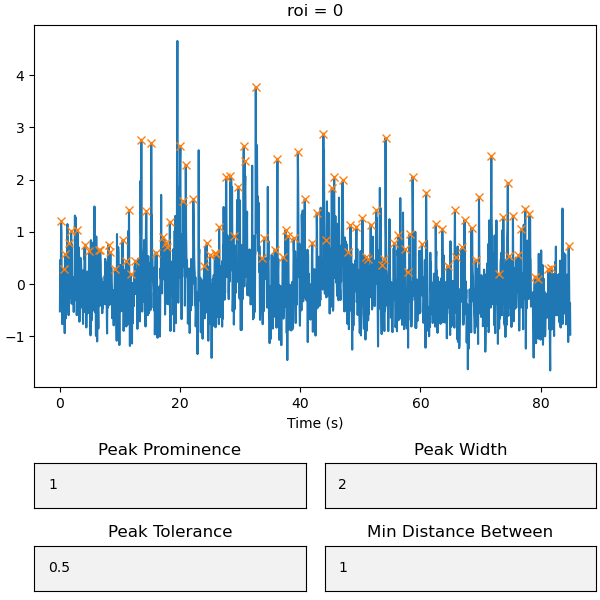

In [10]:
peak_explorer = PeakExplorer(
    recs_xaxis, 
    recs,
    prominence=1,
    width=2,
    tolerance=.5,
    distance=1
)

### Create response triggered average of stimulus movie, and use a rough transformation of the cell ROI to calculate the average intensity over time.
- `roi_idx` sets the ROI used to generate the triggered stimulus. Make use of the mask and beam scrollers above to pick out ROIs that you might want to do this with
- `lead` sets the time (in seconds) to use preceding each threshold passing event.
- peak finding parameters correspond to those above, set them here in order to influence the stimulus triggered window calculation.
- `max_prominence` sets a clip off point for peaks, such that errantly large events do not completely wash out the rest (due to prominence scaling using softmax). This is optional, and can be set to `None` or commented out from the arguments given to `avg_trigger_window`.

The dotted blue outline represents the relative postion and size of the recording scan field. This can be removed by simply changing the value in the conditional to `0` (or `False`). 

<IPython.core.display.Javascript object>


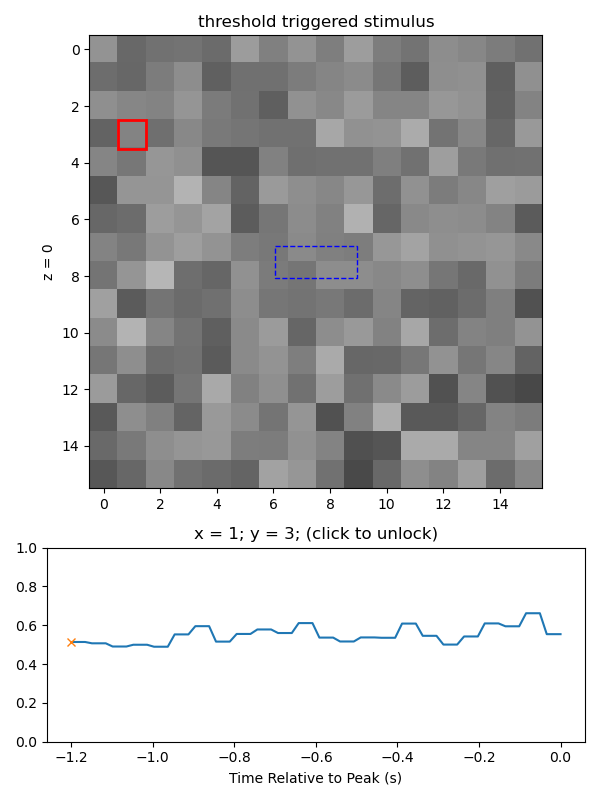

In [11]:
# interesting ROIs: 24, 31, 36, 37, 40
roi_idx = 40
lead = 1.2

threshold = 2.
peak_width = 2
peak_tolerance = .5
min_peak_interval = 1
max_prominence = 4  # clip to avoid dominance by errant peaks

peak_idxs, peak_props = signal.find_peaks(
    recs[roi_idx],
    prominence=threshold,
    width=peak_width,
    rel_height=peak_tolerance,
    distance=min_peak_interval
)

lead_stack = avg_trigger_window(
    noise_xaxis, 
    raw_noise,
    recs_xaxis,
    recs[roi_idx],
    lead,
    peak_idxs,
    prominences=peak_props["prominences"],
    max_prominence=max_prominence  
)

lead_xaxis = np.linspace(
    lead_stack.shape[0] * (-1 / 60), 0, lead_stack.shape[0],
)

lead_stack_plot = StackExplorer(
    lead_stack,
    zaxis=lead_xaxis,
    delta=1,
    roi_sz=1,
    vmin=0,
    vmax=1,
    figsize=(6, 8)
)
lead_stack_plot.ax[0].set_title("threshold triggered stimulus")
lead_stack_plot.ax[1].set_xlabel("Time Relative to Peak (s)")
lead_stack_plot.fig.tight_layout()

# outline of scan field (guide for where to look for receptive field)
# NOTE: PD scans are offset (stims is centered to DD scan field)
if 1:
    x_corner_phys = (stim_width - rec_width) / 2
    y_corner_phys = (stim_height - rec_height) / 2
    x_corner_scaled = x_corner_phys / stim_width * raw_noise.shape[2]
    y_corner_scaled = y_corner_phys / stim_height * raw_noise.shape[1]

    field = Rectangle(
        (x_corner_scaled - .5, y_corner_scaled - .5),  # grid offset
        rec_width / stim_width * raw_noise.shape[2], 
        rec_height / stim_height * raw_noise.shape[1], 
        fill=False,
        color="blue",
        linewidth=1,
        linestyle="--"
    )
    lead_stack_plot.ax[0].add_patch(field)

lead_stack_plot.fig.show()

### Rough "receptive field" map via response vs baseline subtraction

<IPython.core.display.Javascript object>


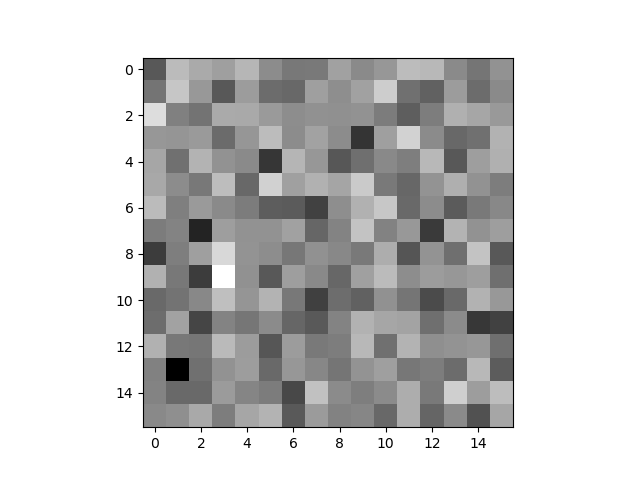

In [12]:
bsln_t0 = -.500
bsln_t1 = -.400
resp_t0 = -.250
resp_t1 = -.150

bsln_mask = (bsln_t0 <= lead_xaxis) * (lead_xaxis <= bsln_t1)
bsln = np.mean(lead_stack[bsln_mask], axis=0)
resp_mask = (resp_t0 <= lead_xaxis) * (lead_xaxis <= resp_t1)
resp = np.mean(lead_stack[resp_mask], axis=0)

sub_field_fig, sub_field_ax = plt.subplots(1)
sub_field_ax.imshow(resp - bsln, cmap="gray")

### Randomly triggered stimulus for comparison

Sampling N windows from the stimulus randomly, where N is the number of peaks found in the target ROI above. This is presented for comparison to get a feel for how variable the averages are with this number of samples, as well as to see how often "receptive field" like signals emerge by chance. 

<IPython.core.display.Javascript object>


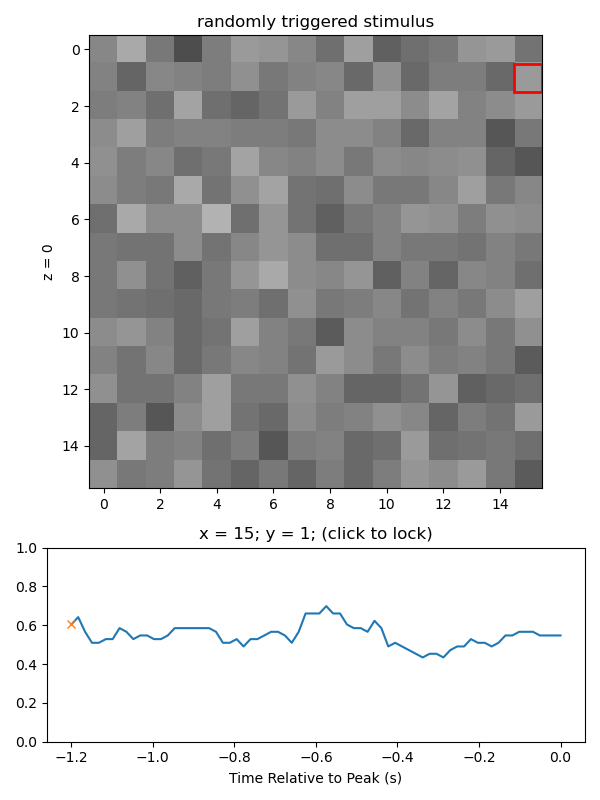

In [13]:
ts = np.random.uniform(
    low=(np.min(noise_xaxis) + lead), 
    high=np.max(noise_xaxis),
    size=len(peak_idxs)
)
random_lead_stack = np.mean([
    lead_window(noise_xaxis, raw_noise, t, lead) for t in ts
], axis=0)

random_lead_stack_plot = StackExplorer(
    random_lead_stack,
    zaxis=lead_xaxis,
    delta=1,
    roi_sz=1,
    vmin=0,
    vmax=1,
    figsize=(6, 8)
)
random_lead_stack_plot.ax[0].set_title("randomly triggered stimulus")
random_lead_stack_plot.ax[1].set_xlabel("Time Relative to Peak (s)")
random_lead_stack_plot.fig.tight_layout()

### Comparison of recording stack scale to noise stimulus.

<IPython.core.display.Javascript object>


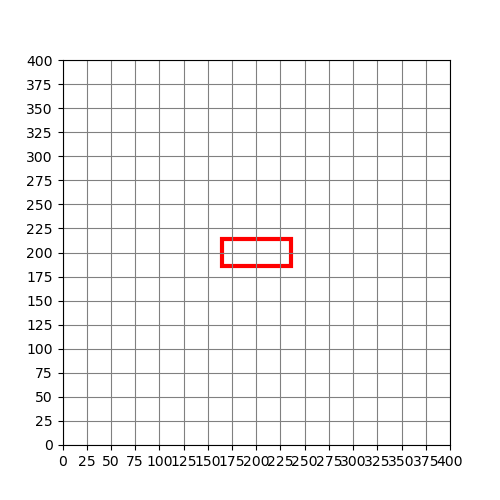

In [14]:
x_corner = (stim_width - rec_width) / 2
y_corner = (stim_height - rec_height) / 2

dims_fig, dims_ax = plt.subplots(1, figsize=(5, 5))
dims_ax.set_ylim(0, stim_height)
dims_ax.set_xlim(0, stim_width)
field = Rectangle(
    (x_corner, y_corner),
    rec_width, 
    rec_height,
    fill=False,
    color="red",
    linewidth=3,
)
dims_ax.add_patch(field)

x_loc = plticker.MultipleLocator(base=(stim_width / 16))
y_loc = plticker.MultipleLocator(base=(stim_height / 16))
dims_ax.xaxis.set_major_locator(x_loc)
dims_ax.yaxis.set_major_locator(y_loc)
dims_ax.grid(which='major', axis='both', linestyle='-', c="grey")

### Compare raw and filtered responses for ROIs
Use scroll wheel over the figure to cycle through ROIs. Threshold for highlighted events can be set with `thresh` variable. This just provides a visual, and does not impact further analysis later on.

<IPython.core.display.Javascript object>


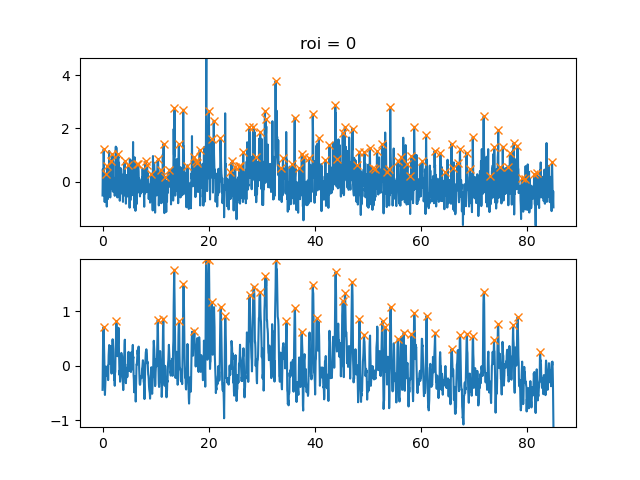

In [15]:
beam_idx = 0  # here to be manipulated by beams_onscroll, leave as is
n_beams = recs.shape[0]
thresh = 1
peak_width = 2
peak_tolerance = .5
min_peak_interval = 1

raw_peaks, _ = signal.find_peaks(recs[beam_idx], height=thresh)
filt_peaks, _ = signal.find_peaks(filtered[beam_idx], height=thresh)
beams_fig, beams_ax = plt.subplots(2)
lines = [
    [
        beams_ax[0].plot(recs_xaxis, recs[beam_idx]),
        beams_ax[0].plot(recs_xaxis[raw_peaks], recs[beam_idx, raw_peaks], "x"),
    ],
    [ 
        beams_ax[1].plot(recs_xaxis, filtered[beam_idx]),
        beams_ax[1].plot(recs_xaxis[filt_peaks], filtered[beam_idx, filt_peaks], "x"),
    ]
]

beams_ax[0].set_ylim(recs.min(), recs.max())
beams_ax[1].set_ylim(filtered.min(), filtered.max())


def beams_update():
    beams_ax[0].set_title("roi = %i" % beam_idx)
    for ax, ln, data in zip(beams_ax, lines, [recs, filtered]):
        ln[0][0].set_ydata(data[beam_idx])
        peaks, _ = signal.find_peaks(
            data[beam_idx],
            prominence=thresh,
            rel_height=peak_tolerance,
            width=peak_width,
            distance=min_peak_interval
        )                             
        ln[1][0].set_data(recs_xaxis[peaks], data[beam_idx, peaks])
        ax.set_ylim(data[beam_idx].min(), data[beam_idx].max())
        beams_fig.canvas.draw()
        

def beams_onscroll(event):
    global beam_idx
    if event.button == "up":
        beam_idx = (beam_idx + 1) % n_beams
    else:
        beam_idx = (beam_idx - 1) % n_beams
    beams_update()


beams_fig.canvas.mpl_connect("scroll_event", beams_onscroll)
beams_update()
beams_fig.show()

In [16]:
def correlation_lags(in1_len, in2_len, mode='full'):
    """Copied from:
    https://github.com/scipy/scipy/blob/v1.6.0/scipy/signal/signaltools.py#L286
    Not present in the installed version of scipy.signal 
    """
    if mode == "full":
        lags = np.arange(-in2_len + 1, in1_len)
    elif mode == "same":
        lags = np.arange(-in2_len + 1, in1_len)
        mid = lags.size // 2
        lag_bound = in1_len // 2
        if in1_len % 2 == 0:
            lags = lags[(mid-lag_bound):(mid+lag_bound)]
        else:
            lags = lags[(mid-lag_bound):(mid+lag_bound)+1]
    elif mode == "valid":
        lag_bound = in1_len - in2_len
        if lag_bound >= 0:
            lags = np.arange(lag_bound + 1)
        else:
            lags = np.arange(lag_bound, 1)
    return lags

<IPython.core.display.Javascript object>


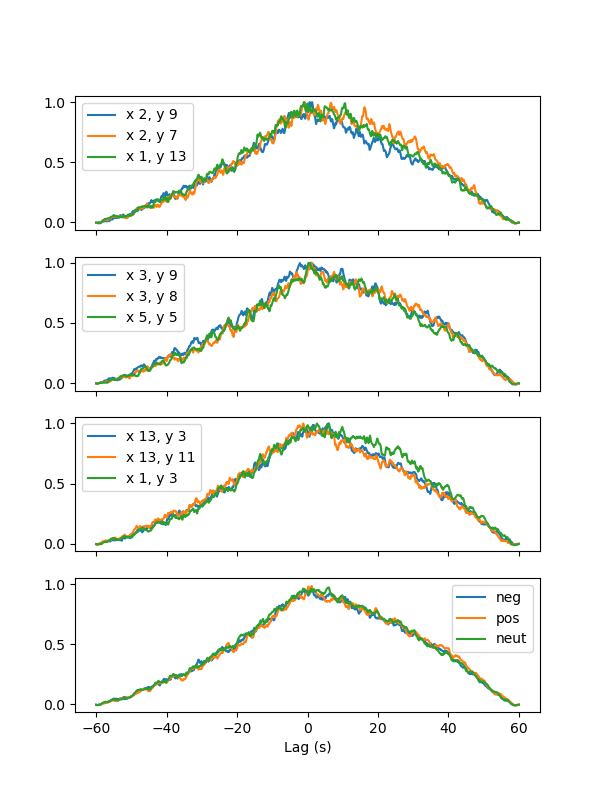

In [50]:
# taking a look at what cross correlations look like between ROI
# signals and beams pulled from the noise

cropped_rec = recs[roi_idx, 200:1400]
norm_rec = cropped_rec / np.max(cropped_rec)
norm_rec = signal.resample(norm_rec, norm_rec.size * 3) # 20Hz -> 60Hz
lags = correlation_lags(raw_noise.shape[0], norm_rec.size) * (1 / 60)

def cross_corr(a, b, norm=True):
    corr = moving_avg(signal.correlate(a, b), 75)
    return corr / np.max(corr) if norm else corr

def labeled_corr(x, y):
    lbl = "x %i, y %i" % (x, y)
    return lbl, cross_corr(raw_noise[:, y, x], norm_rec)

# indices from roi_idx = 40
# negative contrast triggered average pixels
lbl1, corr1 = labeled_corr(2, 9)
lbl2, corr2 = labeled_corr(2, 7)
lbl3, corr3 = labeled_corr(1, 13)

# postive contrast triggered average pixels
lbl4, corr4 = labeled_corr(3, 9)
lbl5, corr5 = labeled_corr(3, 8)
lbl6, corr6 = labeled_corr(5, 5)

# neutral contrast triggered average pixels
lbl7, corr7 = labeled_corr(13, 3)
lbl8, corr8 = labeled_corr(13, 11)
lbl9, corr9 = labeled_corr(1, 3)

test_fig, test_ax = plt.subplots(4, sharex=True, sharey=True, figsize=(6, 8))
test_ax[0].plot(lags, corr1, label=lbl1)
test_ax[0].plot(lags, corr2, label=lbl2)
test_ax[0].plot(lags, corr3, label=lbl3)
test_ax[0].legend()
test_ax[1].plot(lags, corr4, label=lbl4)
test_ax[1].plot(lags, corr5, label=lbl5)
test_ax[1].plot(lags, corr6, label=lbl6)
test_ax[1].legend()
test_ax[2].plot(lags, corr7, label=lbl7)
test_ax[2].plot(lags, corr8, label=lbl8)
test_ax[2].plot(lags, corr9, label=lbl9)
test_ax[2].legend()
test_ax[3].plot(lags, np.mean([corr1, corr2, corr3], axis=0), label="neg")
test_ax[3].plot(lags, np.mean([corr4, corr5, corr6], axis=0), label="pos")
test_ax[3].plot(lags, np.mean([corr7, corr8, corr9], axis=0), label="neut")
test_ax[3].legend()
test_ax[3].set_xlabel("Lag (s)")
test_fig.show()